#### Files
##### train.csv
* building_id - Foreign key for the building metadata.
* meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
* timestamp - When the measurement was taken
* meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.

##### building_meta.csv
* site_id - Foreign key for the weather files.
* building_id - Foreign key for training.csv
* primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* square_feet - Gross floor area of the building
* year_built - Year building was opened
* floor_count - Number of floors of the building

##### weather_[train/test].csv
Weather data from a meteorological station as close as possible to the site.

* site_id
* air_temperature - Degrees Celsius
* cloud_coverage - Portion of the sky covered in clouds, in oktas
* dew_temperature - Degrees Celsius
* precip_depth_1_hr - Millimeters
* sea_level_pressure - Millibar/hectopascals
* wind_direction - Compass direction (0-360)
* wind_speed - Meters per second

##### test.csv
The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.
* row_id - Row id for your submission file
* building_id - Building id code
* meter - The meter id code
* timestamp - Timestamps for the test data period

##### sample_submission.csv
A valid sample submission.

All floats in the solution file were truncated to four decimal places; we recommend you do the same to save space on your file upload.
There are gaps in some of the meter readings for both the train and test sets. Gaps in the test set are not revealed or scored.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
building_df = pd.read_csv("../datasets/ashrae-energy-prediction/building_metadata.csv")
train_df = pd.read_csv("../datasets/ashrae-energy-prediction/train.csv")
test_df = pd.read_csv("../datasets/ashrae-energy-prediction/test.csv")
weather_train_df = pd.read_csv("../datasets/ashrae-energy-prediction/weather_train.csv")
weather_test_df = pd.read_csv("../datasets/ashrae-energy-prediction/weather_test.csv")
sample_submission_df = pd.read_csv("../datasets/ashrae-energy-prediction/sample_submission.csv")


In [3]:
building_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [4]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [5]:
test_df.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [6]:
weather_test_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [7]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [8]:
sample_submission_df.head()

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [9]:
print(train_df.shape)
train_df.info()

(20216100, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [10]:
print(weather_train_df.shape)
weather_train_df.info()

(139773, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [11]:
print(building_df.shape)
building_df.info()

(1449, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [12]:
print(weather_test_df.shape)
weather_test_df.info()

(277243, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
site_id               277243 non-null int64
timestamp             277243 non-null object
air_temperature       277139 non-null float64
cloud_coverage        136795 non-null float64
dew_temperature       276916 non-null float64
precip_depth_1_hr     181655 non-null float64
sea_level_pressure    255978 non-null float64
wind_direction        264873 non-null float64
wind_speed            276783 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 19.0+ MB


In [13]:
print(test_df.shape)
test_df.info()

(41697600, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
row_id         int64
building_id    int64
meter          int64
timestamp      object
dtypes: int64(3), object(1)
memory usage: 1.2+ GB


In [14]:
train_df['meter'].value_counts()

0    12060910
1     4182440
2     2708713
3     1264037
Name: meter, dtype: int64

0: electricity, 1: chilledwater, 2: steam, 3: hotwater

In [15]:
print(building_df['site_id'].unique())
building_df['site_id'].value_counts()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


3     274
13    154
2     135
15    124
9     124
0     105
14    102
4      91
5      89
8      70
1      51
6      44
12     36
10     30
7      15
11      5
Name: site_id, dtype: int64

In [16]:
# nan_values={'year_built':np.around(np.mean(building_df['year_built'])),'floor_count':np.around(np.mean(building_df['floor_count']))}
# building_df=building_df.fillna(value=nan_values)
# building_df.info()

In [17]:
# nan_values={'air_temperature':np.around(np.mean(weather_train_df['air_temperature']),decimals=1),'cloud_coverage':np.around(np.mean(weather_train_df['cloud_coverage'])),'dew_temperature':np.around(np.mean(weather_train_df['dew_temperature']),decimals=1),'precip_depth_1_hr':np.around(np.mean(weather_train_df['precip_depth_1_hr'])),'sea_level_pressure':np.around(np.mean(weather_train_df['sea_level_pressure']),decimals=1),'wind_direction':np.around(np.mean(weather_train_df['wind_direction'])),'wind_speed':np.around(np.mean(weather_train_df['wind_speed']),decimals=1)}
# weather_train_df=weather_train_df.fillna(value=nan_values)
# weather_train_df.info()

In [18]:
# nan_values={'air_temperature':np.around(np.mean(weather_test_df['air_temperature']),decimals=1),'cloud_coverage':np.around(np.mean(weather_test_df['cloud_coverage'])),'dew_temperature':np.around(np.mean(weather_test_df['dew_temperature']),decimals=1),'precip_depth_1_hr':np.around(np.mean(weather_test_df['precip_depth_1_hr'])),'sea_level_pressure':np.around(np.mean(weather_test_df['sea_level_pressure']),decimals=1),'wind_direction':np.around(np.mean(weather_test_df['wind_direction'])),'wind_speed':np.around(np.mean(weather_test_df['wind_speed']),decimals=1)}
# weather_test_df=weather_test_df.fillna(value=nan_values)
# weather_test_df.info()

In [19]:
count_row_train = train_df.shape[0]
count_row_test = test_df.shape[0]

In [20]:
train_df = train_df.loc[:count_row_train*0.1-1]
test_df = test_df.loc[:count_row_test*0.1-1]

In [21]:
train_df.shape

(2021610, 4)

In [22]:
test_df.shape

(4169760, 4)

In [23]:
building_merge_train_df = train_df.merge(building_df, on='building_id', how='left')
df_train = building_merge_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')

In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2021610 entries, 0 to 2021609
Data columns (total 16 columns):
building_id           int64
meter                 int64
timestamp             object
meter_reading         float64
site_id               int64
primary_use           object
square_feet           int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtypes: float64(10), int64(4), object(2)
memory usage: 262.2+ MB


In [25]:
building_merge_test_df = test_df.merge(building_df, on='building_id', how='left')
df_test = building_merge_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')

In [26]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4169760 entries, 0 to 4169759
Data columns (total 16 columns):
row_id                int64
building_id           int64
meter                 int64
timestamp             object
site_id               int64
primary_use           object
square_feet           int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtypes: float64(9), int64(5), object(2)
memory usage: 540.8+ MB


In [39]:
df_train.isna().sum()

building_id                 0
meter                       0
timestamp                   0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
year_built            1207684
floor_count           1669339
air_temperature         26059
cloud_coverage         984698
dew_temperature         26722
precip_depth_1_hr      366543
sea_level_pressure     175433
wind_direction         112254
wind_speed              29745
dtype: int64

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2021610 entries, 0 to 2021609
Data columns (total 16 columns):
building_id           int64
meter                 int64
timestamp             object
meter_reading         float64
site_id               int64
primary_use           object
square_feet           int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtypes: float64(10), int64(4), object(2)
memory usage: 262.2+ MB


0    60.349177
1    19.756827
2    13.640811
3     6.253184
Name: meter, dtype: float64


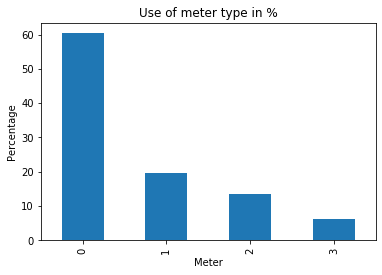

In [43]:
meter_percent = df_train.meter.value_counts('percent')*100
print(meter_percent)
meter_percent.plot(kind='bar')
plt.title("Use of meter type in %")
plt.ylabel("Percentage")
plt.xlabel("Meter")
plt.show()

meter type code 0 i.e electricity is used 60.35%, chilledwater->19.76%, steam->13.64% ,hotwater->6.25%

In [46]:
print(df_train['site_id'].unique())
df_train['site_id'].value_counts()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


13    271361
9     267485
2     252757
14    249208
3     237201
15    207954
0      90395
5      78320
4      71753
8      58814
6      57933
1      55434
10     43122
7      36908
12     31605
11     11360
Name: site_id, dtype: int64

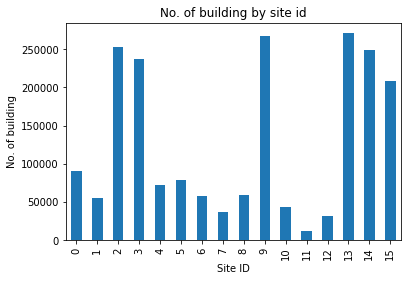

In [45]:
df_train.groupby('site_id')['building_id'].count().plot(kind='bar')
plt.title("No. of building by site id")
plt.ylabel("No. of building")
plt.xlabel("Site ID")
plt.show()

Most of building are at site_id 13 i.e 271361 and less building are at 11 i.e 11360

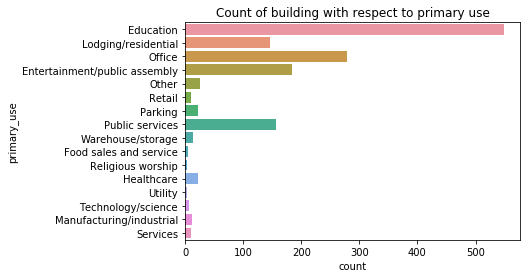

In [30]:
sns.countplot(y='primary_use',data=building_df)
plt.title("Count of building with respect to primary use")
plt.show()

* We can say that most of the building are educational building followed by office, assembly, public service, residential and more.
* Also most of the energy utilize by educational building but not confirm which type of energy

In [31]:
print(building_df['year_built'].unique())
building_df['year_built'].value_counts()

[2008. 2004. 1991. 2002. 1975. 2000. 1981. 1989. 2003. 2010. 1968. 1999.
 2013. 1974. 1996. 1980. 1977. 1990. 1985. 2001. 1969. 2005. 2016. 2006.
 2014. 1970. 1971. 2011. 1997. 2007. 1998. 2009. 1979. 1986. 1982. 1983.
   nan 1913. 1953. 1909. 1958. 1960. 1976. 1906. 1900. 1995. 1956. 1930.
 1967. 1919. 1955. 1965. 1907. 2012. 1992. 1948. 1950. 1941. 1957. 1964.
 1940. 1951. 1966. 1934. 1959. 1993. 1939. 1918. 1963. 1987. 1914. 1973.
 1988. 1935. 1942. 2015. 1931. 1928. 1929. 1908. 1927. 1923. 1962. 1944.
 1910. 1949. 2017. 1922. 1911. 1932. 1978. 1912. 1916. 1924. 1926. 1904.
 1984. 1903. 1925. 1961. 1921. 1972. 1936. 1954. 1905. 1920. 1917. 1952.
 1994. 1933. 1945. 1938. 1915. 1947. 1946. 1902. 1937.]


1976.0    55
1966.0    23
1968.0    18
1919.0    17
1964.0    15
          ..
1934.0     1
1936.0     1
1926.0     1
2017.0     1
1947.0     1
Name: year_built, Length: 116, dtype: int64

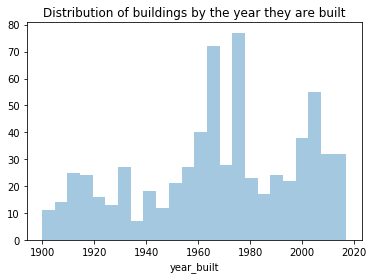

In [32]:
sns.distplot(building_df['year_built'].dropna(),bins=24,kde=False)
plt.title('Distribution of buildings by the year they are built')
plt.show()

building are build mostly at 1976 its 55

In [33]:
print(building_df['floor_count'].unique())
building_df['floor_count'].value_counts()

[nan  5.  4. 10.  6.  8.  7.  9. 13. 16. 11. 12.  2.  3.  1. 14. 21. 26.
 19.]


1.0     109
2.0      67
4.0      37
3.0      33
5.0      25
6.0      25
8.0      19
7.0      14
9.0       8
11.0      5
10.0      4
12.0      2
13.0      2
19.0      1
26.0      1
14.0      1
21.0      1
16.0      1
Name: floor_count, dtype: int64

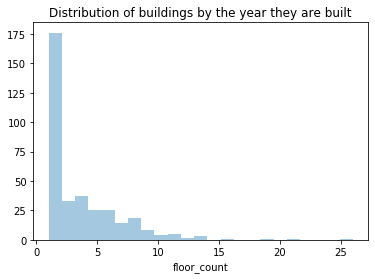

In [34]:
sns.distplot(building_df['floor_count'].dropna(),kde=False)
plt.title('Distribution of buildings by the year they are built')
plt.show()

In [42]:
df_train['timestamp'] = pd.to_datetime(df_train.timestamp)
df_test['timestamp'] = pd.to_datetime(df_test.timestamp)